**Link to Whole data dictionary**    
https://support.google.com/analytics/answer/3437719?hl=en

In [1]:
# import libraries
import os
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew 
from datetime import datetime, timedelta
from sklearn import preprocessing

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# import warnings

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
os.chdir('../../')

In [3]:
os.getcwd()

'C:\\Users\\betty\\OneDrive\\Documents\\GitHub\\theme\\Google-Store-Analytics-Transactions-Revenue-Prediction'

1. Dataset info

In [4]:
# read the data
path = 'dataset/clean_data/'
train_df = pd.read_pickle(path+'2017_clean.pkl')

In [5]:
#train_df.shape
print("Datasets contains %s of features, and %s of rows."%(train_df.shape[1],train_df.shape[0]))
print("Number of unique visitors in train set : ",train_df.fullVisitorId.nunique(), " out of rows : ",train_df.shape[0])

Datasets contains 38 of features, and 928860 of rows.
Number of unique visitors in train set :  716705  out of rows :  928860


In [6]:
# understand the quantity of misisng values
missing_values_count = train_df.isnull().sum().sort_values(ascending=False)
missing_values_per = round((missing_values_count/len(train_df)) * 100,2)
pd.concat([missing_values_count, missing_values_per], axis=1, keys = ['Quant Missing values', 'Percentage Missing values - %'])

,Quant Missing values,Percentage Missing values - %
totals.totalTransactionRevenue,918372,98.87
totals.transactionRevenue,918372,98.87
totals.transactions,918372,98.87
trafficSource.adContent,877334,94.45
trafficSource.adwordsClickInfo.isVideoAd,868324,93.48
trafficSource.adwordsClickInfo.slot,868324,93.48
trafficSource.adwordsClickInfo.page,868324,93.48
trafficSource.adwordsClickInfo.adNetworkType,868324,93.48
trafficSource.adwordsClickInfo.gclId,868252,93.48
trafficSource.referralPath,695059,74.83


* In terms of of total revenue, about 1.2%of customers is generating the total revenues
* More missing values related to traffic source, might need to dig more into it.
* Some of NA (missing values) also contains values based on data dictionary. EX: Binary (1 and Na is 0)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928860 entries, 0 to 928859
Data columns (total 38 columns):
channelGrouping                                 928860 non-null object
date                                            928860 non-null int64
fullVisitorId                                   928860 non-null object
visitId                                         928860 non-null int64
visitNumber                                     928860 non-null int64
visitStartTime                                  928860 non-null int64
device.browser                                  928860 non-null object
device.operatingSystem                          928860 non-null object
device.isMobile                                 928860 non-null bool
device.deviceCategory                           928860 non-null object
geoNetwork.continent                            928860 non-null object
geoNetwork.subContinent                         928860 non-null object
geoNetwork.country                         

2. Change Dataset into Right Format

    This will save up more memory space

In [8]:
# library of datetime
from datetime import datetime

# This function is to extract date, weekdays, day,month and visitHour features
def date_process(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["_weekday"] = df['date'].dt.weekday #extracting week day
    df["_day"] = df['date'].dt.day # extracting day
    df["_month"] = df['date'].dt.month # extracting day
    df["_year"] = df['date'].dt.year # extracting day
    df['_visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    
    return df #returning the df after the transformations
train_df = date_process(train_df) #calling the function that we created above

In [9]:
#change dataset into right format, then we can also save some memory space
#fill missing values(0,1/True,False)
train_df['totals.bounces'] = train_df['totals.bounces'].fillna(0)
train_df['totals.newVisits'] =train_df['totals.newVisits'].fillna(0)
train_df['trafficSource.isTrueDirect'] =train_df['trafficSource.isTrueDirect'].fillna('False')
train_df['trafficSource.adwordsClickInfo.slot'] = train_df['trafficSource.adwordsClickInfo.slot'].fillna('None')
train_df['trafficSource.adwordsClickInfo.adNetworkType'] = train_df['trafficSource.adwordsClickInfo.adNetworkType'].fillna('Unknown')
#train_df['totals.timeOnSite'] = train_df['totals.timeOnSite'].fillna(0)
#train_df['totals.transactions'] = train_df['totals.transactions'].fillna(0)
#train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].fillna(0.0)
#train_df['totals.totalTransactionRevenue'] = train_df['totals.totalTransactionRevenue'].fillna(0)
train_df['trafficSource.adwordsClickInfo.page'] = train_df['trafficSource.adwordsClickInfo.page'].fillna(0)
train_df['totals.hits']=train_df['totals.hits'].fillna(0)
train_df.loc[train_df['geoNetwork.city'] == "(not set)", 'geoNetwork.city'] = np.nan
train_df['geoNetwork.city'].fillna("NaN", inplace=True)
#change format of dataset
train_df['channelGrouping']=train_df['channelGrouping'].astype('category')
train_df['device.browser']=train_df['device.browser'].astype('category')
train_df['device.operatingSystem']=train_df['device.operatingSystem'].astype('category')
train_df['device.isMobile']=train_df['device.isMobile'].astype('category')
train_df['device.deviceCategory']=train_df['device.deviceCategory'].astype('category')
train_df['geoNetwork.continent']=train_df['geoNetwork.continent'].astype('category')
train_df['geoNetwork.subContinent']=train_df['geoNetwork.subContinent'].astype('category')
train_df['geoNetwork.country']=train_df['geoNetwork.country'].astype('category')
train_df['geoNetwork.region']=train_df['geoNetwork.region'].astype('category')
train_df['geoNetwork.city']=train_df['geoNetwork.city'].astype('category')
train_df['geoNetwork.networkDomain']=train_df['geoNetwork.networkDomain'].astype('category')
train_df['totals.hits']=train_df['totals.hits'].astype('int')                              
train_df['totals.pageviews']=train_df['totals.pageviews'].astype('float')
train_df['totals.bounces']=train_df['totals.bounces'].astype('float')
train_df['totals.newVisits']=train_df['totals.newVisits'].astype('float')
train_df['totals.sessionQualityDim']=train_df['totals.sessionQualityDim'].astype('float')
train_df['totals.timeOnSite']=train_df['totals.timeOnSite'].astype('float')                         
train_df['totals.transactions']=train_df['totals.transactions'].astype('float')                         
train_df['totals.transactionRevenue']=train_df['totals.transactionRevenue'].astype('float')                      
train_df['totals.totalTransactionRevenue']=train_df['totals.totalTransactionRevenue'].astype('float')
train_df['trafficSource.campaign'] =train_df['trafficSource.campaign'].astype('category')           
train_df['trafficSource.source']=train_df['trafficSource.source'].astype('category')                   
train_df['trafficSource.medium']=train_df['trafficSource.medium'].astype('category')                                                          
train_df['trafficSource.isTrueDirect']=train_df['trafficSource.isTrueDirect'].astype('category')
train_df['trafficSource.adwordsClickInfo.slot']=train_df['trafficSource.adwordsClickInfo.slot'].astype('category')
train_df['trafficSource.adwordsClickInfo.adNetworkType']=train_df['trafficSource.adwordsClickInfo.adNetworkType'].astype('category')
train_df['trafficSource.adwordsClickInfo.page']=train_df['trafficSource.adwordsClickInfo.page'].astype('int')

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928860 entries, 0 to 928859
Data columns (total 43 columns):
channelGrouping                                 928860 non-null category
date                                            928860 non-null datetime64[ns]
fullVisitorId                                   928860 non-null object
visitId                                         928860 non-null int64
visitNumber                                     928860 non-null int64
visitStartTime                                  928860 non-null int64
device.browser                                  928860 non-null category
device.operatingSystem                          928860 non-null category
device.isMobile                                 928860 non-null category
device.deviceCategory                           928860 non-null category
geoNetwork.continent                            928860 non-null category
geoNetwork.subContinent                         928860 non-null category
geoNetwork.country

In [11]:
train_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,_weekday,_day,_month,_year,_visitHour
0,Organic Search,2017-10-16,3162355547410993243,1508198450,1,1508198450,Firefox,Windows,False,desktop,Europe,Western Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),1,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,(not set),google,organic,water bottle,NaN,False,NaN,0,None,NaN,Unknown,NaN,0,16,10,2017,19
1,Referral,2017-10-16,8934116514970143966,1508176307,6,1508176307,Chrome,Chrome OS,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,(not set),2,2.0,0.0,0.0,2.0,28.0,NaN,NaN,NaN,(not set),sites.google.com,referral,NaN,/a/google.com/transportation/mtv-services/bike...,False,NaN,0,None,NaN,Unknown,NaN,0,16,10,2017,12
2,Direct,2017-10-16,7992466427990357681,1508201613,1,1508201613,Chrome,Android,True,mobile,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,windjammercable.net,2,2.0,0.0,1.0,1.0,38.0,NaN,NaN,NaN,(not set),(direct),(none),NaN,NaN,True,NaN,0,None,NaN,Unknown,NaN,0,16,10,2017,19
3,Organic Search,2017-10-16,9075655783635761930,1508169851,1,1508169851,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,2,2.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,(not set),google,organic,(not provided),NaN,False,NaN,0,None,NaN,Unknown,NaN,0,16,10,2017,11
4,Organic Search,2017-10-16,6960673291025684308,1508190552,1,1508190552,Chrome,Windows,False,desktop,Americas,Central America,Mexico,not available in demo dataset,not available in demo dataset,not available in demo dataset,prod-infinitum.com.mx,2,2.0,0.0,1.0,1.0,52.0,NaN,NaN,NaN,(not set),google,organic,(not provided),NaN,False,NaN,0,None,NaN,Unknown,NaN,0,16,10,2017,16


3. Drop Unecessary Columns

In [12]:
columns_to_drop = ['visitId' ,'visitNumber','visitStartTime','trafficSource.adwordsClickInfo.gclId','totals.transactionRevenue','totals.transactions']
train_df = train_df.drop(columns_to_drop,axis=1)

4. Transaction Revenue Distribution

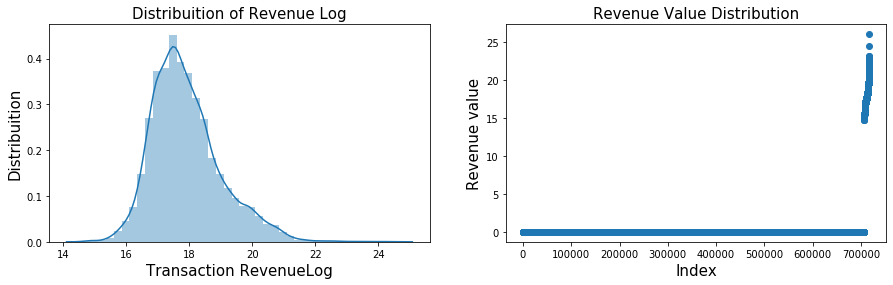

In [13]:
# Revenue
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
ax = sns.distplot(np.log(train_df[train_df['totals.totalTransactionRevenue'] > 0]["totals.totalTransactionRevenue"] + 0.01), bins=40, kde=True)
ax.set_xlabel('Transaction RevenueLog', fontsize=15) 
ax.set_ylabel('Distribuition', fontsize=15)
ax.set_title("Distribuition of Revenue Log", fontsize=15)

plt.subplot(1,2,2) 
gdf = train_df.groupby("fullVisitorId")["totals.totalTransactionRevenue"].sum().reset_index()
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.totalTransactionRevenue"].values)))
plt.xlabel('Index', fontsize=15)
plt.ylabel('Revenue value', fontsize=15)
plt.title("Revenue Value Distribution", fontsize=15)

plt.show()

In [14]:
print('kurtosis of normal distribution (should be 0): {}'.format(
    kurtosis(train_df["totals.totalTransactionRevenue"],nan_policy='omit')))
print( 'Skewness of normal distribution (should be 0): {}'.format(
    skew(train_df["totals.totalTransactionRevenue"],nan_policy='omit')))

kurtosis of normal distribution (should be 0): 1663.5837425123716
Skewness of normal distribution (should be 0): 35.838761035409334


* Skewness:
    - Based on the second graph and kurtosis we can conclude data has heavy tails
    - Based on the skew we can conclude data is highly skewed to the left
    - 1.2% of customer contribute to the revenue

* based on the correlation plot : total transaction has relatively high correlation with visitnumber among continuous variables

5. ChannelGrouping Analysis

Default Channel Definitions: https://support.google.com/analytics/answer/3297892

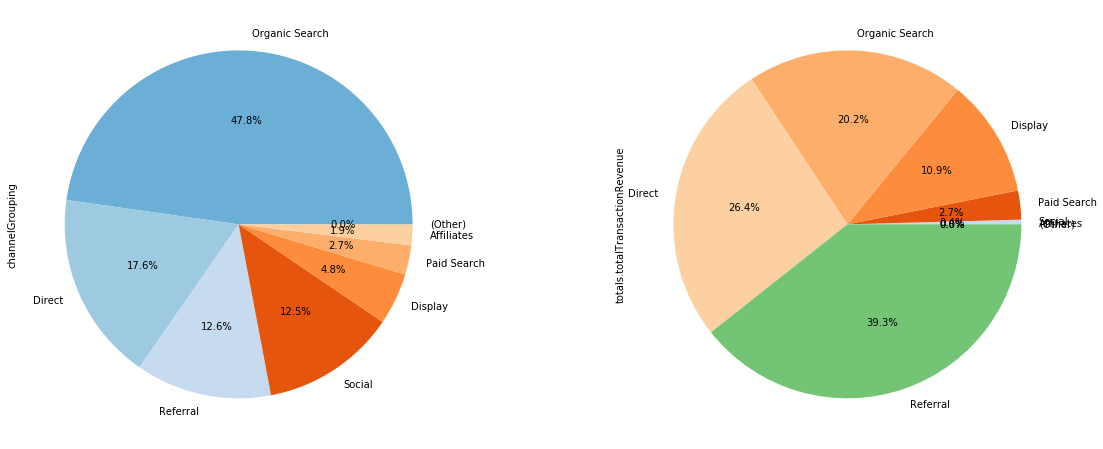

In [15]:
fig, axs = plt.subplots(ncols= 2,figsize=(20,8))

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.array([1, 2, 3, 4, 5, 6, 7, 9]))


ax1 = train_df['channelGrouping'].value_counts().plot.pie(explode=[0, 0, 0, 0, 0, 0, 0, 0], autopct='%1.1f%%',colors=outer_colors, ax =axs[0])
ax2 =train_df.groupby(['channelGrouping'])['totals.totalTransactionRevenue'].sum().sort_values().plot.pie(explode=[0, 0, 0, 0, 0, 0, 0, 0], autopct='%1.1f%%',colors=outer_colors, ax =axs[1])

plt.show()



The TOP 5 Grouping Channels represents 78% of customer units. Respectivelly:

* TOP 1 => Organic Search - 47.8%
* TOP 2 => Direct - 17.6%
* TOP 3 => Referral - 12.6%
* Makes up 98% of 

The TOP 5 Grouping Channels represents up 89.4% of revenue:

* TOP 1 => Referral 41.7%
* TOP 2 => Direct 26.3%
* TOP 3 => Organic Search 21.4%

6 Traffic Source Analysis

	This section contains information about the Traffic Source from which the session originated.

 - trafficSource.medium is the subcategory of the group channel
 - trafficSource.source contains information about the Traffic Source from which the session originated.
 - trafficSource.adwordsClickInfo.isVideoAd (Binary)
 - trafficSource.isTrueDirect (Binary)
     - True if the source of the session was Direct (meaning the user typed the name of your website URL into the browser or came to your site via a bookmark), This field will also be true if 2 successive but distinct sessions have exactly the same campaign details.
 - trafficSource.adwordsClickInfo.slot
     - Position of the Ad. Takes one of the following values:{“RHS", "Top"}
 - trafficSource.adwordsClickInfo.adNetworkType
     - Network Type. Takes one of the following values: {“Google Search", "Content", "Search partners", "Ad Exchange", "Yahoo Japan Search", "Yahoo Japan AFS", “unknown”}


In [16]:
train_df['trafficSource.adwordsClickInfo.isVideoAd']=train_df['trafficSource.adwordsClickInfo.isVideoAd'].fillna('True')

In [17]:
traffic_related = ['trafficSource.source','trafficSource.medium',
                   'trafficSource.isTrueDirect',
                   'trafficSource.adwordsClickInfo.adNetworkType',
                   'trafficSource.adwordsClickInfo.isVideoAd',
                  'trafficSource.adwordsClickInfo.slot'] 

In [18]:
def revenue_vist_plot(data,x,y):
    fig, axs = plt.subplots(ncols= 2,figsize=(25,10))
    cmap = plt.get_cmap("tab20c")

    outer_colors = cmap(np.arange(len(data[x].unique())))
    
   
    data[x].value_counts().plot.pie(explode=np.zeros(len(data[x].unique())), autopct='%1.1f%%',colors=outer_colors, ax =axs[0])
    
    stats = data.groupby([x])[y].sum().sort_values(ascending =False).head(10)
    stats.sort_values().plot(kind = 'barh', ax =axs[1])

plt.show()


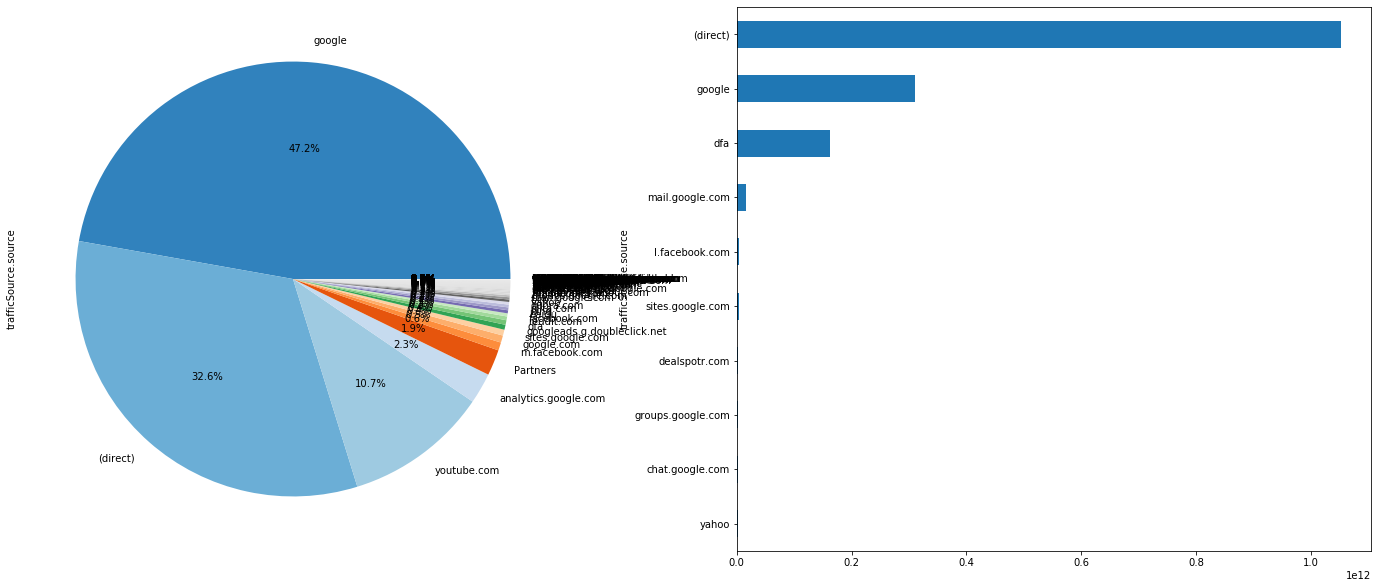

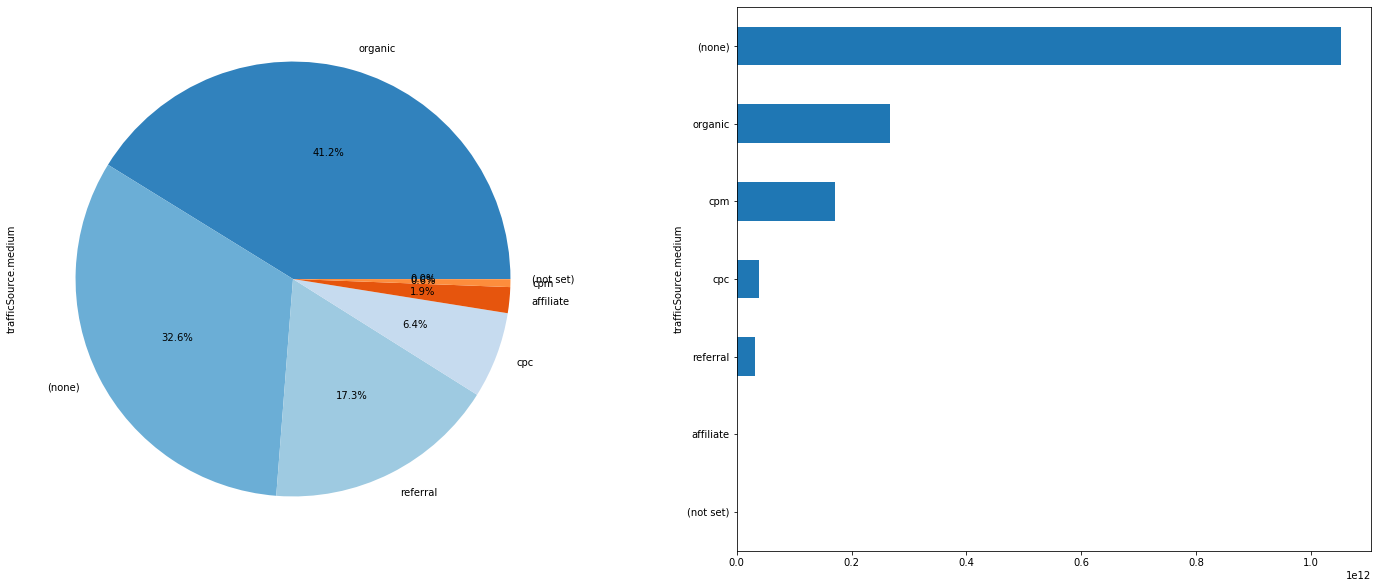

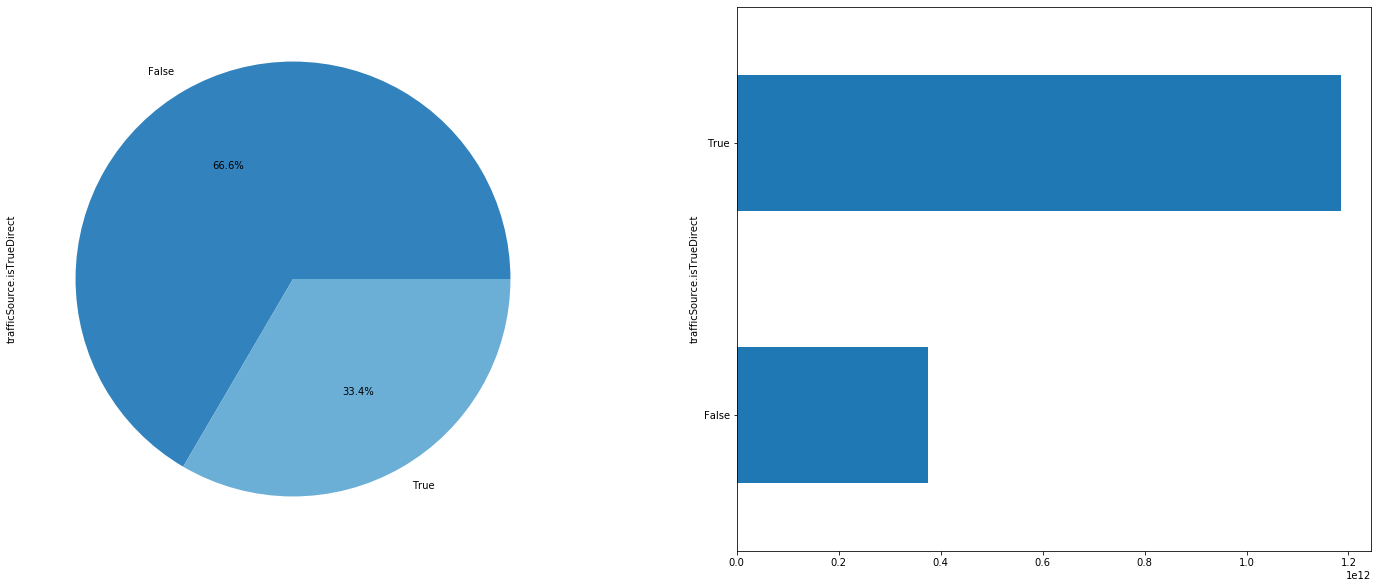

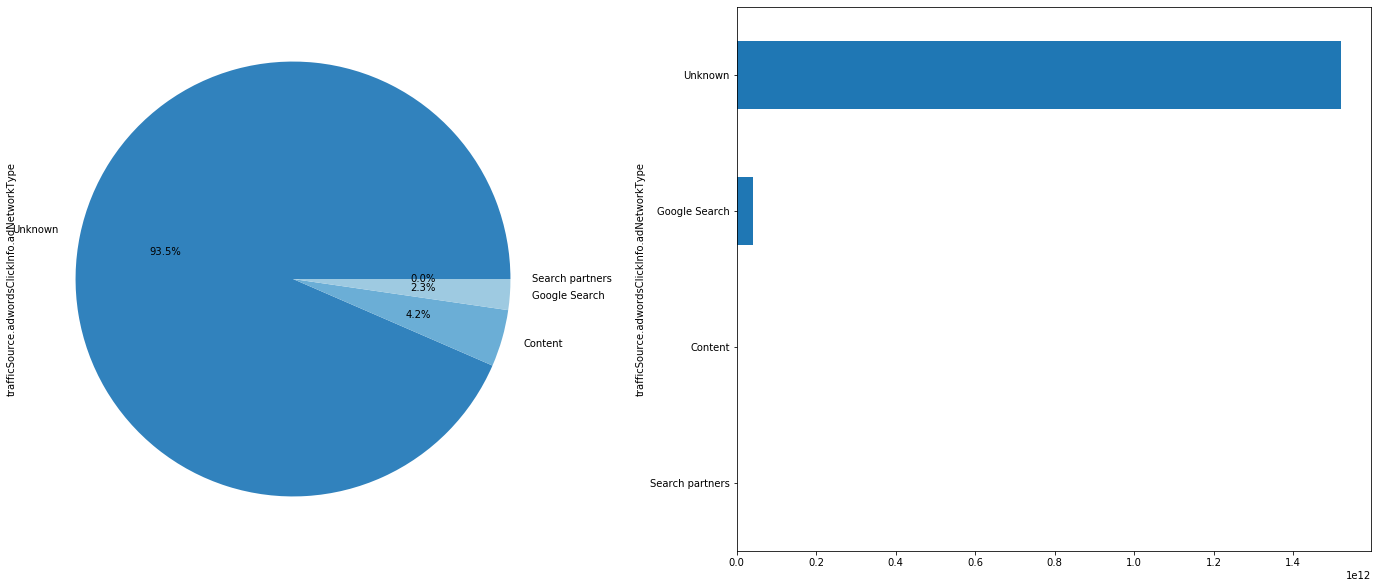

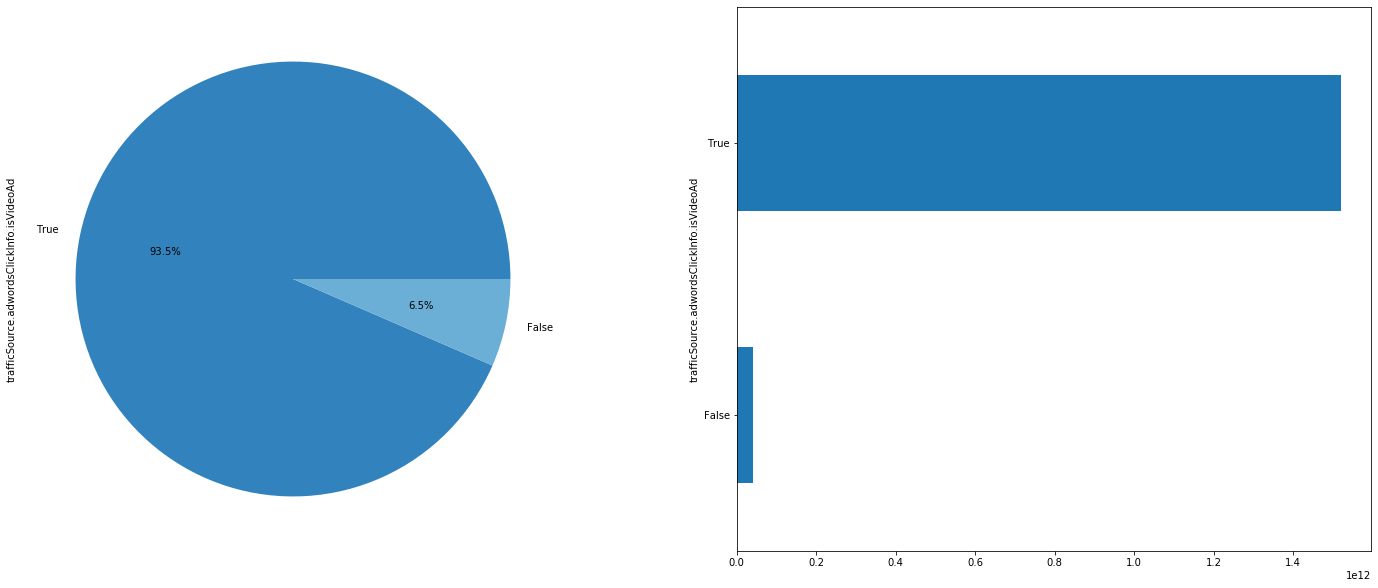

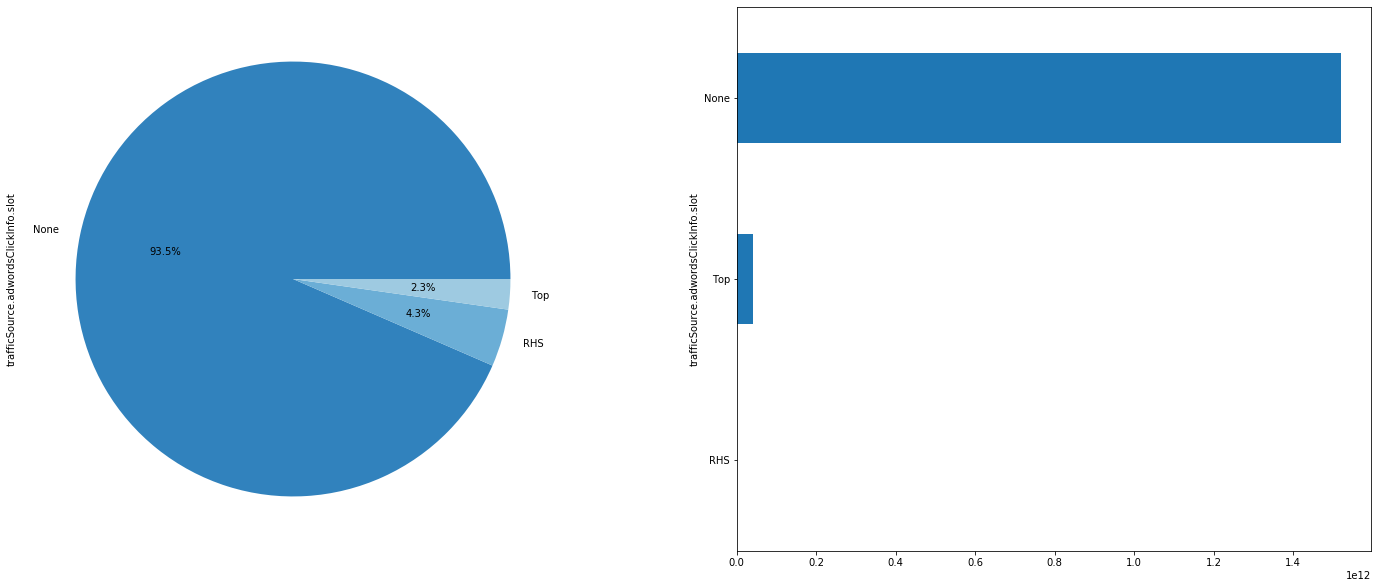

In [19]:
for i in traffic_related:
    revenue_vist_plot(train_df,i,'totals.totalTransactionRevenue')

* Most of traffic source is original from google and direct search
* Can drop traffic network type, and trafficSource slot
* add another variable to combine medium and source

In [20]:
train_df['traffic.medium_source'] = train_df[['trafficSource.source','trafficSource.medium']].apply(lambda x : '{} && {}'.format(x[0],x[1]), axis=1)

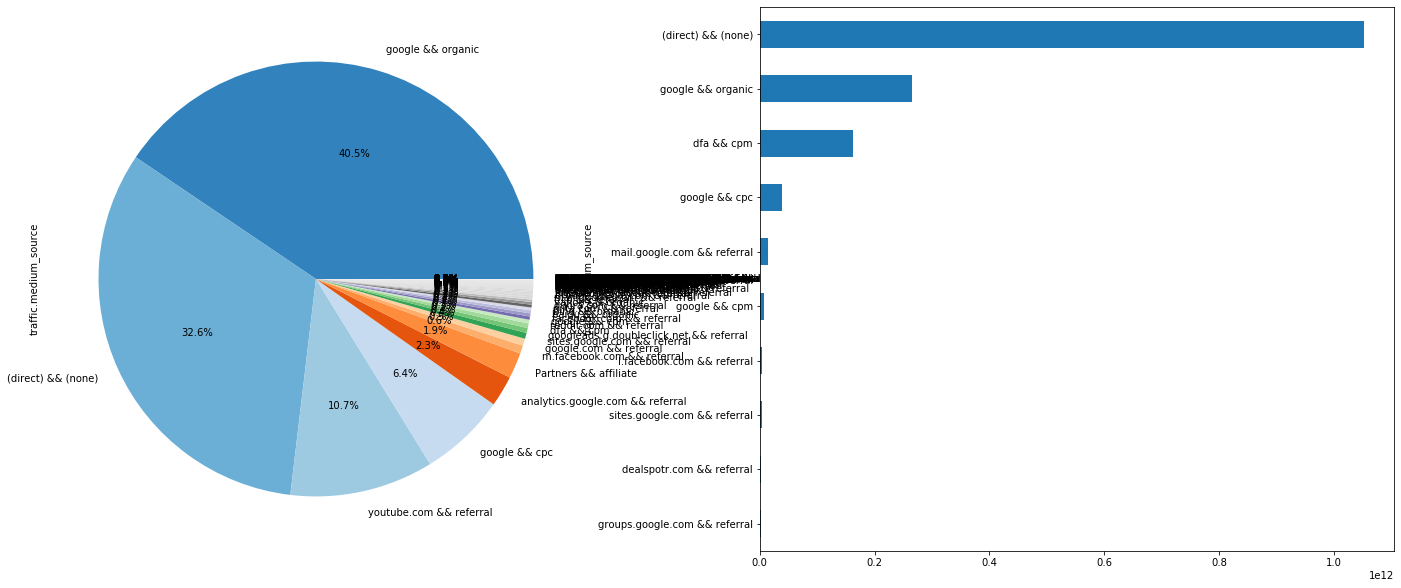

In [21]:
revenue_vist_plot(train_df,'traffic.medium_source','totals.totalTransactionRevenue')

- youtube referral contributes in the top 10 most aggregate revenue

7. TimeSereis Analysis

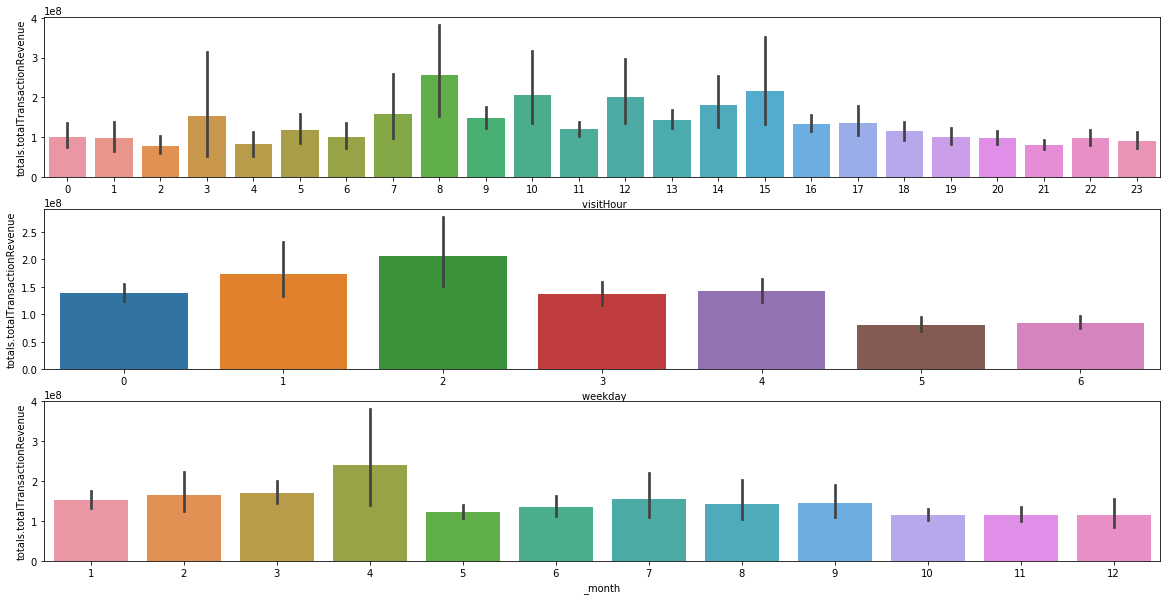

In [22]:
fig, axs = plt.subplots(nrows= 3,figsize=(20,10))

sns.barplot(x="_visitHour", y="totals.totalTransactionRevenue", data=train_df,ax=axs[0])
sns.barplot(x="_weekday", y="totals.totalTransactionRevenue", data=train_df,ax=axs[1])
sns.barplot(x="_month", y="totals.totalTransactionRevenue", data=train_df,ax=axs[2])

plt.show()

- hour 8,12,15 is the peak hours
- Tuesday contributes the most profitable 
- First 4 months generates more revenue

8. Operating System

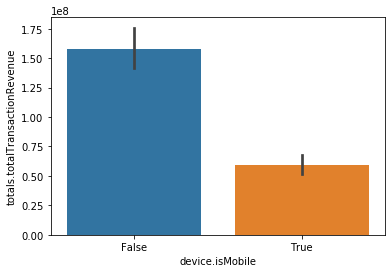

In [23]:
sns.barplot(x='device.isMobile', y='totals.totalTransactionRevenue', data=train_df)

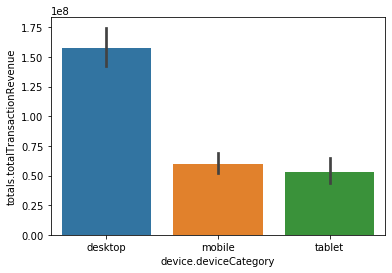

In [24]:
sns.barplot(x="device.deviceCategory", y="totals.totalTransactionRevenue", data=train_df)

<Figure size 720x576 with 0 Axes>

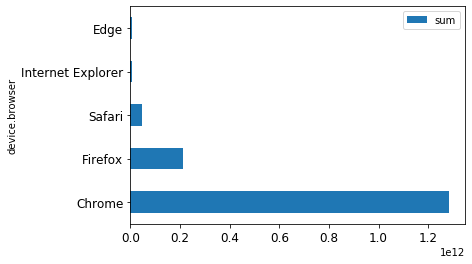

In [25]:
plt.figure(figsize=(10,8))
# revenue
count = train_df.groupby(['device.browser'])['totals.totalTransactionRevenue'].agg(['sum'])
#sns.barplot(x='device.isMobile', y='totals.totalTransactionRevenue', data=train_df)
count.sort_values(['sum'], ascending=False)[:5].plot(kind='barh', fontsize=12)

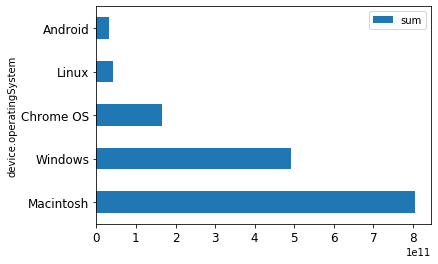

In [26]:
# device browser
count = train_df.groupby('device.operatingSystem')['totals.totalTransactionRevenue'].agg(['sum'])
count.sort_values(['sum'], ascending=False)[:5].plot(kind='barh', fontsize=12)

9. GeoNetwork Columns

`geoNetwork.continent`   
Only 6 groups, ready to use.

Thoughts:
1. Americas has most counts and non-zero revenue.
2. Asia and Europe have high counts but low non-zero revenue.
3. Mean revenue of Africa is high.

In [27]:
# continent
cnt = train_df.groupby('geoNetwork.continent')['totals.totalTransactionRevenue'].agg(['size', 'count', 'mean'])
cnt.columns = ["count", "count of non-zero revenue", "mean"]
cnt = cnt.sort_values(by="count", ascending=False)
cnt

,count,count of non-zero revenue,mean
geoNetwork.continent,,,
Americas,499458,10275,1.488042e+08
Europe,209074,80,9.968250e+07
Asia,187915,110,1.294265e+08
Oceania,16776,16,3.238944e+08
Africa,14387,5,6.823880e+08
(not set),1250,2,2.136500e+07


Text(0.5, 1.0, 'Continent - Revenue Mean')

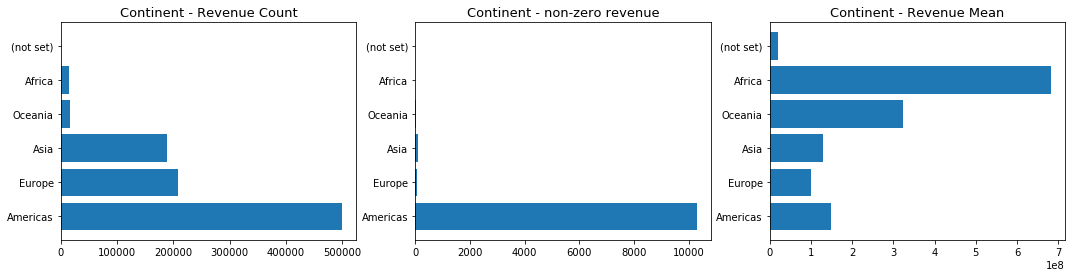

In [28]:
plt.figure(figsize=(18,4))

plt.subplot(1,3,1)
plt.barh(cnt.index.values, cnt['count'])
plt.title("Continent - Revenue Count", fontsize=13)

plt.subplot(1,3,2)
plt.barh(cnt.index.values, cnt['count of non-zero revenue'])
plt.title("Continent - non-zero revenue", fontsize=13)

plt.subplot(1,3,3)
plt.barh(cnt.index.values, cnt['mean'])
plt.title("Continent - Revenue Mean", fontsize=13)

`geoNetwork.subContinent`  
About 20 groups, ready to use.
Similar pattern as continent.

In [29]:
# subcontinent
scnt = train_df.groupby('geoNetwork.subContinent')['totals.totalTransactionRevenue'].agg(['size', 'count', 'mean'])
scnt.columns = ["count", "count of non-zero revenue", "mean"]
scnt = scnt.sort_values(by="count", ascending=False)
scnt.head()

,count,count of non-zero revenue,mean
geoNetwork.subContinent,,,
Northern America,446135,10208,1.484929e+08
Northern Europe,67546,23,1.151735e+08
Western Europe,67240,33,1.075767e+08
Southern Asia,65795,13,7.571385e+07
Eastern Asia,51136,51,1.774249e+08


`geoNetwork.country`  
* United State has only 45% of counts but over 95% of the non-zero revenue. That's interesting. Other countries almost generate no revenue except Canada. But Canada also only generate 174 pieces of non-zero revenue out of 30k counts of visit.

* We may consider drop this column and create a feature **is_US** (1 for country==US, 0 for country!=US).

In [30]:
# country
ct = train_df.groupby('geoNetwork.country')['totals.totalTransactionRevenue'].agg(['size', 'count', 'mean'])
ct.columns = ["count", "count of non-zero revenue", "mean"]
ct = ct.sort_values(by="count", ascending=False)

ct.head()

,count,count of non-zero revenue,mean
geoNetwork.country,,,
United States,416398,10034,1.487837e+08
India,57370,13,7.571385e+07
United Kingdom,45618,14,1.395700e+08
Canada,29687,174,1.317232e+08
Germany,22542,7,8.743857e+07


In [31]:
train_df[train_df['geoNetwork.country']=='United States']['totals.totalTransactionRevenue'].count()/train_df['totals.totalTransactionRevenue'].count()

0.9567124332570557

In [32]:
len(train_df[train_df['geoNetwork.country']=='United States']['totals.totalTransactionRevenue'])/len(train_df['totals.totalTransactionRevenue'])

0.448289300863424

Text(0.5, 1.0, 'Country - Revenue Mean')

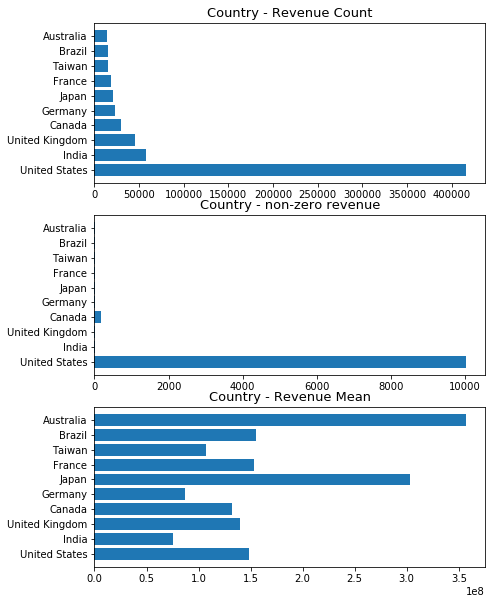

In [33]:
# plot top 10
ct_10 = ct.head(10)

plt.figure(figsize=(7,10))

plt.subplot(3,1,1)
plt.barh(ct_10.index.values, ct_10['count'])
plt.title("Country - Revenue Count", fontsize=13)

plt.subplot(3,1,2)
plt.barh(ct_10.index.values, ct_10['count of non-zero revenue'])
plt.title("Country - non-zero revenue", fontsize=13)

plt.subplot(3,1,3)
plt.barh(ct_10.index.values, ct_10['mean'])
plt.title("Country - Revenue Mean", fontsize=13)

`geoNetwork.region`   
* For non-zero revenue, region not available is nearly 40%. Among the remaining, California is the most and is above 30%.

In [34]:
# city
city = train_df.groupby('geoNetwork.city')['totals.totalTransactionRevenue'].agg(['size', 'count', 'mean'])
city.columns = ["count", "count of non-zero revenue", "mean"]
city = city.sort_values(by="count", ascending=False)

city.head(20)

,count,count of non-zero revenue,mean
geoNetwork.city,,,
not available in demo dataset,517806,4052,1.822869e+08
Mountain View,39494,1198,1.027948e+08
NaN,34185,54,1.088648e+08
New York,27900,1247,1.394442e+08
San Francisco,21145,644,1.361777e+08
Sunnyvale,15475,507,9.018682e+07
London,14178,12,1.221542e+08
San Jose,11311,223,8.695448e+07
Los Angeles,10347,276,1.625361e+08


Text(0.5, 1.0, 'Continent - Revenue Mean')

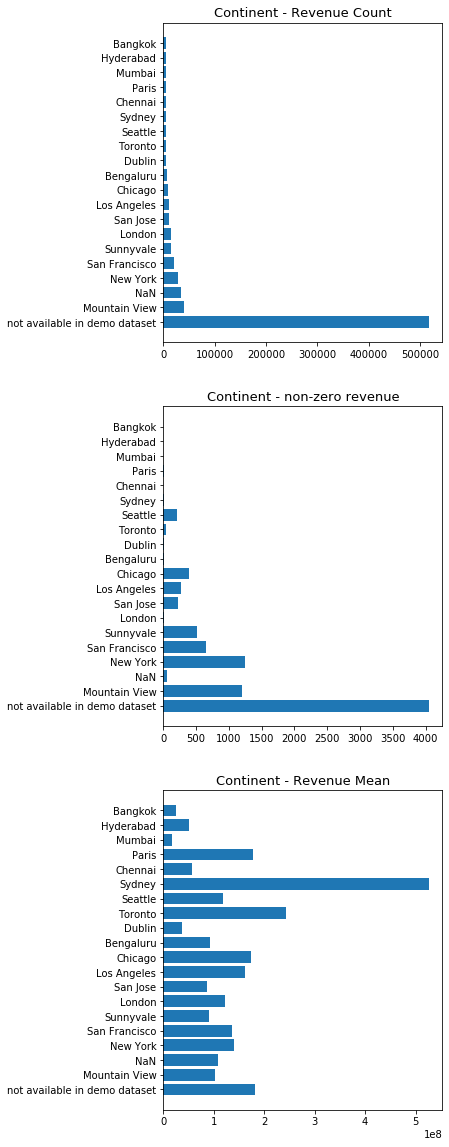

In [35]:
# plot top 20
city_20 = city.head(20)

plt.figure(figsize=(5,20))

plt.subplot(3,1,1)
plt.barh(city_20.index.values, city_20['count'])
plt.title("Continent - Revenue Count", fontsize=13)

plt.subplot(3,1,2)
plt.barh(city_20.index.values, city_20['count of non-zero revenue'])
plt.title("Continent - non-zero revenue", fontsize=13)

plt.subplot(3,1,3)
plt.barh(city_20.index.values, city_20['mean'])
plt.title("Continent - Revenue Mean", fontsize=13)

`geoNetwork.networkDomain` 
* About 29K domains, including unknown.unknown and (not set). It is interesting to find out that (not set) has better revenue than unknown.unknown.
* Looks like this column is ready to use.

* Clean up networkDomain and just keep ending like edu,net,com

In [36]:
train_df['domain'] = train_df['geoNetwork.networkDomain'].str.split('.')
train_df['domain'] = [i[-1] for i in train_df['domain']]

In [38]:
# networkDomain
dm = train_df.groupby('domain')['totals.totalTransactionRevenue'].agg(['size', 'count', 'mean'])
dm.columns = ["count", "count of non-zero revenue", "mean"]
dm = dm.sort_values(by="count", ascending=False)

dm.head()

,count,count of non-zero revenue,mean
domain,,,
(not set),291104,6217,1.276356e+08
net,189245,2668,2.172256e+08
unknown,134260,366,1.040605e+08
com,88768,921,1.310978e+08
in,14531,4,3.776250e+07


Text(0.5, 1.0, 'Domain - Revenue Mean')

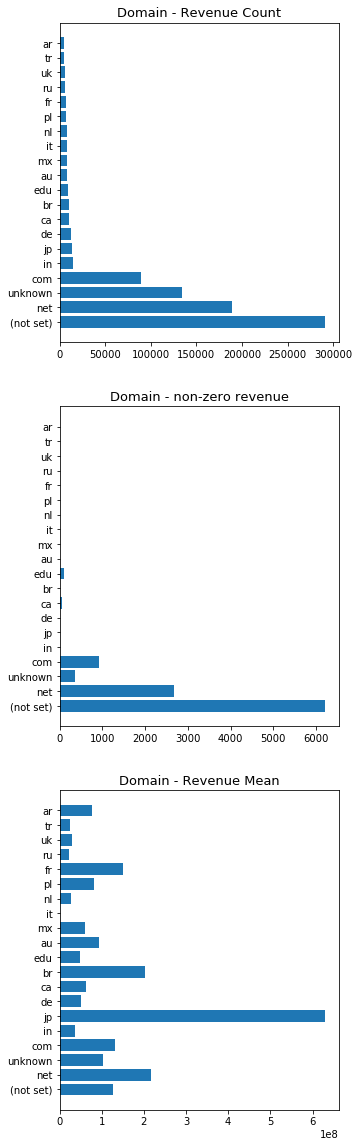

In [39]:
# plot top 20
dm20 = dm.head(20)

plt.figure(figsize=(5,20))

plt.subplot(3,1,1)
plt.barh(dm20.index.values, dm20['count'])
plt.title("Domain - Revenue Count", fontsize=13)

plt.subplot(3,1,2)
plt.barh(dm20.index.values, dm20['count of non-zero revenue'])
plt.title("Domain - non-zero revenue", fontsize=13)

plt.subplot(3,1,3)
plt.barh(dm20.index.values, dm20['mean'])
plt.title("Domain - Revenue Mean", fontsize=13)

10. Totals Columns Analysis

In [40]:
# train_df['totals.timeOnSite'] = train_df['totals.timeOnSite'].fillna(0)
# train_df['totals.transactions'] = train_df['totals.transactions'].fillna(0)
# train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].fillna(0.0)
# train_df['totals.totalTransactionRevenue'] = train_df['totals.totalTransactionRevenue'].fillna(0)

In [42]:
columns=['totals.hits',
 'totals.pageviews',
 'totals.sessionQualityDim',
 'totals.timeOnSite',
 'totals.totalTransactionRevenue']
train_total=train_df[columns]

In [43]:
def correlation_plot(data,col):
    
    fig, ax = plt.subplots(figsize = (10, 10))
    matrix = np.triu(data[col].corr())
    sns.heatmap(data[col].corr(), annot=True, mask=matrix,fmt=".1f",cmap=sns.cubehelix_palette(8))
    
    plt.show()

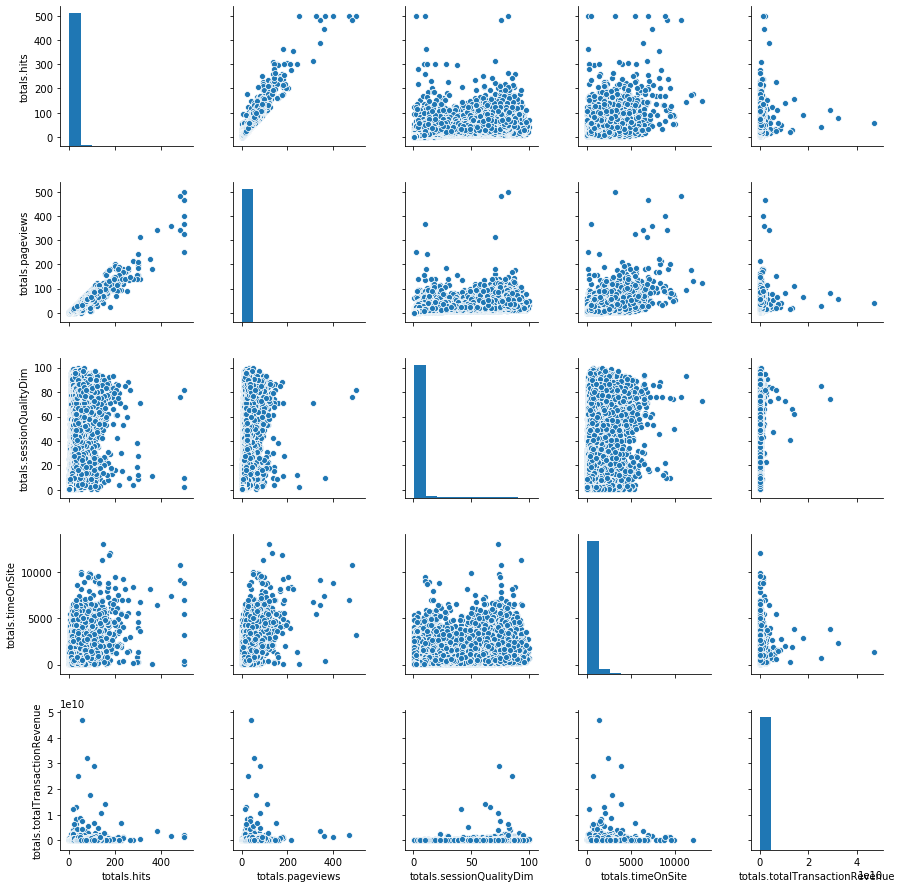

In [44]:
g = sns.pairplot(train_total)

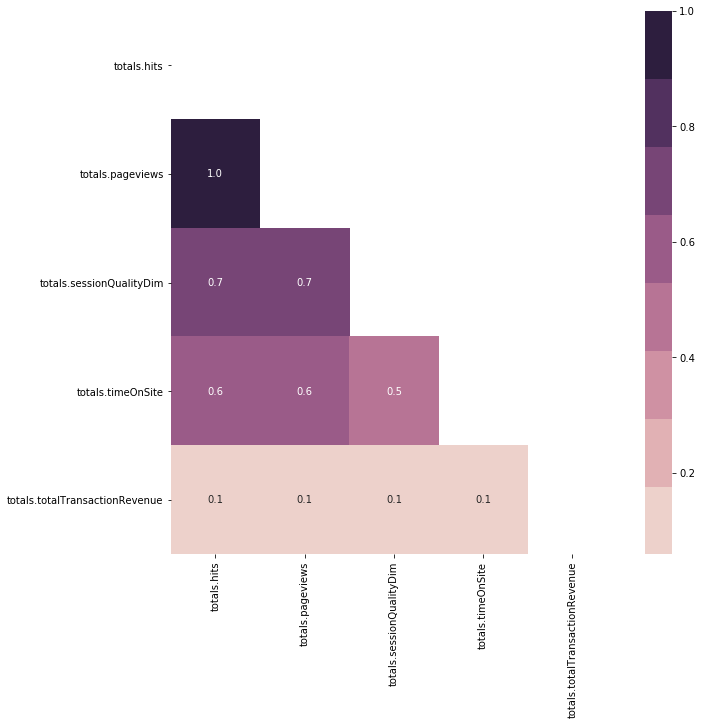

In [45]:
correlation_plot(train_df,columns)

* I think we can drop either total hits or page views since they share almost same information about customers and they have same correlation with revenue

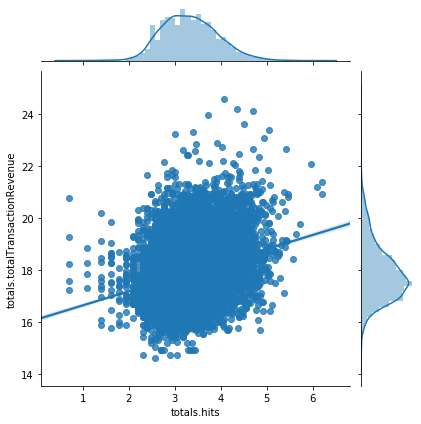

In [46]:
#sns.jointplot(x=train_df['totals.hits'], y=train_df['totals.transactionRevenue'],color ='g')
g=sns.jointplot(x=np.log(train_df['totals.hits']), y=np.log(train_df['totals.totalTransactionRevenue']),kind="reg")

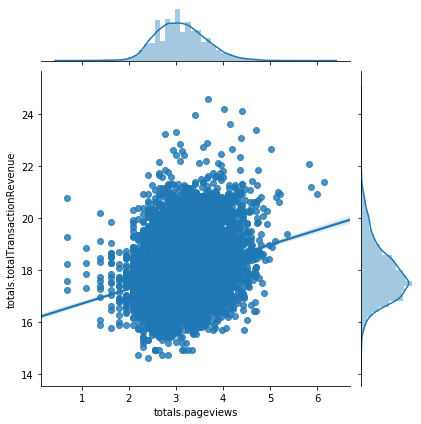

In [47]:
g=sns.jointplot(x=np.log(train_df['totals.pageviews']), y=np.log(train_df['totals.totalTransactionRevenue']),kind="reg")

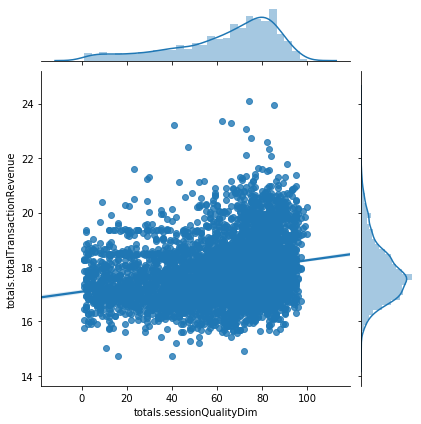

In [48]:
g=sns.jointplot(train_df['totals.sessionQualityDim'], y=np.log(train_df['totals.totalTransactionRevenue']),kind="reg")

* Both page views and total hits is highly correlated to each other. After log transformation, with simple linear regressions. Both total hits and page views is positively related to log of transaction revenues.

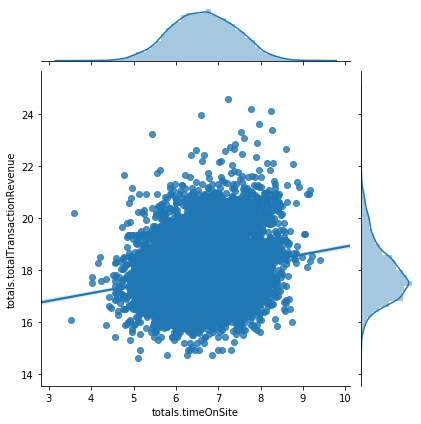

In [49]:
g=sns.jointplot(np.log(train_df['totals.timeOnSite']), y=np.log(train_df['totals.totalTransactionRevenue']),kind="reg")

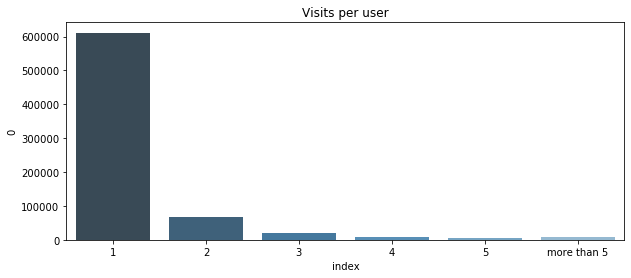

In [50]:
tmp = train_df.groupby('fullVisitorId').size().value_counts().to_frame().reset_index()
sum_ = tmp[tmp['index'].astype('int16') > 5][0].sum()
tmp = tmp.head(5).append(pd.DataFrame({'index': ['more than 5'], 0: [sum_]})).reset_index()
plt.figure(figsize=(10,4))
plt.title("Visits per user")
ax = sns.barplot(x=tmp['index'], y=tmp[0], palette='Blues_d')

`total.timeOnSite`

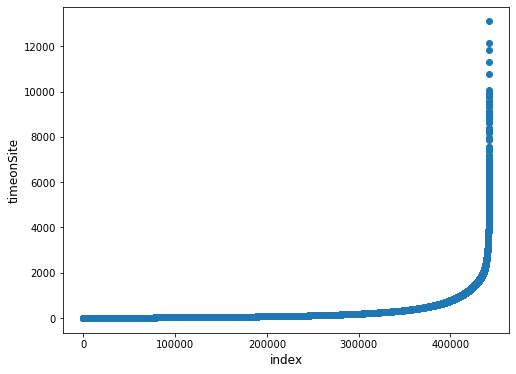

In [51]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df['totals.timeOnSite'].shape[0]), np.sort((train_df['totals.timeOnSite'].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('timeonSite', fontsize=12)
plt.show()

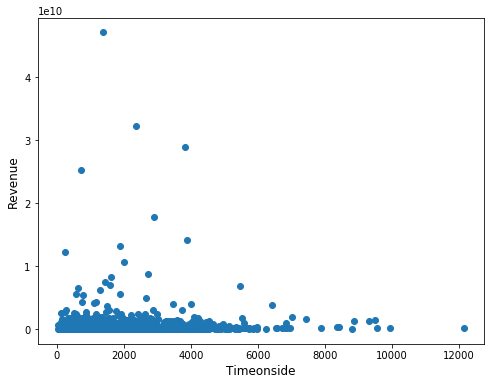

In [52]:
plt.figure(figsize=(8,6))
plt.scatter(train_df['totals.timeOnSite'], train_df['totals.totalTransactionRevenue'])
plt.xlabel('Timeonside', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.show()